In [298]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import ndimage

path = "./PanoramaImages/ImageSet5/"
files = os.listdir(path)

images_bottom = []
images_top = []

for file in files:
    if file != ".DS_Store":
        image_path = path + file
        img = cv.imread(image_path,0)
        img = cv.resize(img,(256,256))
        name = file.split(".")[0]
        if name[len(name) - 3:] == "Top":
            print(file)
            images_top.append(img)
        else:
            print(file)
            images_bottom.append(img)

sift = cv.xfeatures2d.SIFT_create()

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

# bf = cv.BFMatcher()
# matches = bf.knnMatch(des1,des2, k=2)
flann = cv.FlannBasedMatcher(index_params,search_params)

Image1Bottom.jpeg
Image1Top.jpeg
Image2Bottom.jpeg
Image2Top.jpeg
Image3Bottom.jpeg
Image3Top.jpeg
Image4Bottom.jpeg
Image4Top.jpeg


In [299]:
def panoramic_image(images_bottom,images_top,image,i):
    
    if i == len(images_top):
        return image
    
    if i == 0:
        img1_bottom = images_bottom[0]
        img2_bottom = images_bottom[1]
        
        img1_top = images_top[0]
        img2_top = images_top[1]
        
        img1 = stitch_vertically(img1_top,img1_bottom)
        
        img1 = cropImage(img1)
        
        img2 = stitch_vertically(img2_top,img2_bottom)
        img2 = cropImage(img2)
        
        kp1,kp2,des1,des2 = find_keypoints(img1,img2)
         
        H = find_homography(kp1,kp2,des1,des2)
        
        if len(H) > 0 :
            dst = stitch_images(img1,img2,H)
            plt.imshow(dst),plt.title("yo")
            plt.show()
            plt.figure()
            return panoramic_image(images_bottom,images_top,dst,i + 2)
    
    else:
        dst1 = image
        img2_bottom = images_bottom[i]
        img2_top = images_top[i]
        
        img2 = stitch_vertically(img2_top,img2_bottom)
        
        kp1,kp2,des1,des2 = find_keypoints(dst1,img2)
        
        H = find_homography(kp1,kp2,des1,des2)
        
        if len(H) > 0 :
            print(i)
            dst = stitch_images(dst1,img2,H)
            plt.imshow(dst),plt.title(str(i))
            plt.show()
            plt.figure()
            return panoramic_image(images_bottom,images_top,dst,i + 1)

        
def stitch_vertically(img_top,img_bottom):
    rows,cols = img_top.shape
    M = cv.getRotationMatrix2D((cols/2,rows/2),90,1)
    dst1 = cv.warpAffine(img_top,M,(cols,rows))

    rows,cols = img_bottom.shape
    M = cv.getRotationMatrix2D((cols/2,rows/2),90,1)
    dst2 = cv.warpAffine(img_bottom,M,(cols,rows))
    
    kp1,kp2,des1,des2 = find_keypoints(dst1,dst2)
         
    H = find_homography(kp1,kp2,des1,des2)

    if len(H) > 0 :
        dst = stitch_images(dst1,dst2,H)
#         rows,cols = dst.shape
#         M = cv.getRotationMatrix2D((cols/2,rows/2),270,1)
#         dst2 = cv.warpAffine(dst,M,(cols,rows))
        dst2 = ndimage.rotate(dst, 270)
        return dst2

    
def cropImage(image):
    leftWidth = 0
    rightWidth = 10000
    flag1 = 0
    flag2 = 0
    
    i1 = image.shape[0]//10
    i2 = image.shape[0] - i1
    for i in range(image.shape[1]):
        if image[i1][i] != 0 and i > leftWidth and flag1 != 1:
            leftWidth = i
            flag1 = 1
        
        if image[i2][i] != 0 and i > leftWidth and flag2 != 1:
            leftWidth = i
            flag2 = 1
        
        if flag1 == 1 and flag2 == 1:
            break
            
    flag1 = 0
    flag2 = 0
    for i in range(image.shape[1]-1 ,0 ,-1):
        if image[i1][i] != 0 and i < rightWidth and flag1 != 1:
            rightWidth = i
            flag1 = 1
        
        if image[i2][i] != 0 and i < rightWidth and flag2 != 1:
            rightWidth = i
            flag2 = 1
            
        if flag1 == 1 and flag2 == 1:
            break
    
    image = image[:,leftWidth:rightWidth]
    
    return image


def find_homography(kp1,kp2,des1,des2):
    matches = flann.knnMatch(des1,des2,k = 2)
    good = []
    for i , (m, n) in enumerate(matches):
        if m.distance < 0.65*n.distance:
            good.append((m.trainIdx, m.queryIdx))
            
    print(len(good))

    if len(good) >= 4:
        pointsCurrent = kp2
        pointsPrevious = kp1

        matchedPointsCurrent = np.float32(
            [pointsCurrent[i].pt for (i, __) in good]
        )
        matchedPointsPrev = np.float32(
            [pointsPrevious[i].pt for (__, i) in good]
            )

        H, s = cv.findHomography(matchedPointsCurrent, matchedPointsPrev, cv.RANSAC, 5)
#         print(H)
        return H
    else:
        print("cant find enough keypoints")
        return []
    

def stitch_images(img1,img2,H):
    dst = cv.warpPerspective(img2,H,(img2.shape[1] + img1.shape[1], img1.shape[0]))
    plt.imshow(dst),plt.title('Warped Image')
    plt.show()
    plt.figure()
    
    rows,cols = dst.shape
    M = np.float32([[1,0,-1],[0,1,0]])
    dst = cv.warpAffine(dst,M,(cols,rows))

    dst[:,:img1.shape[1]] = img1
    
    
#     for i in range(dst.shape[0]):
#         for j in range(img1.shape[1] - 3, img1.shape[1] + 3):
#             dst[i][j] = np.uint8((dst[i][j - 1] + dst[i][j + 1])/2)
    
    dst = cropImage(dst)
#     width = 0
#     for i in range(dst.shape[1]-1 ,0 ,-1):
#         if dst[0][i] != 0:
#             width = i
#             break
    
#     dst = dst[:,:width -4]
#     print("stitch")
#     plt.imshow(dst)
#     plt.show()
    
    return dst


def find_keypoints(img1,img2):
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    des1 = np.array(des1)
    des2 = np.array(des2)
    
    return kp1,kp2,des1,des2

69


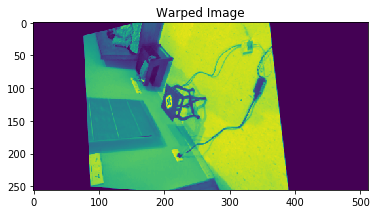

29


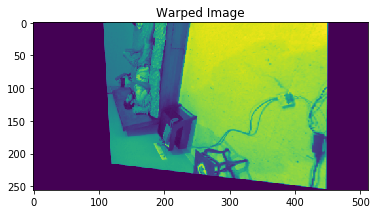

50


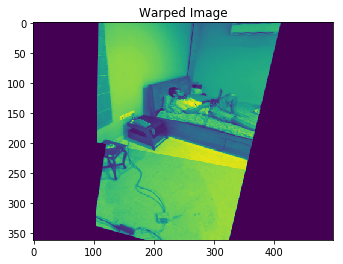

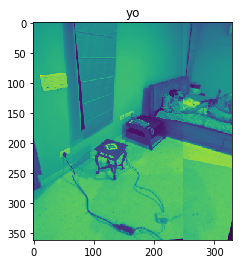

50


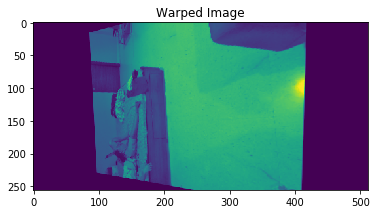

9
2


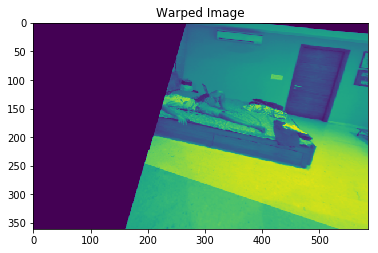

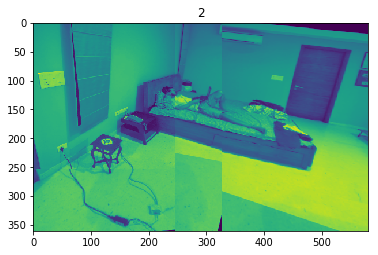

30


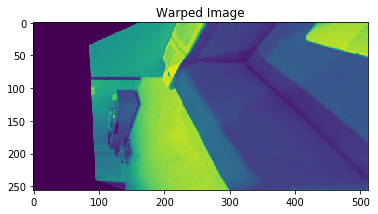

3
cant find enough keypoints


<Figure size 432x288 with 0 Axes>

In [300]:
p_image = panoramic_image(images_bottom,images_top,images_bottom[2],0)
# plt.imshow(p_image)

30
here


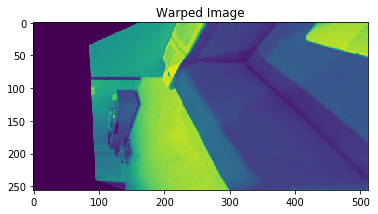

50
here


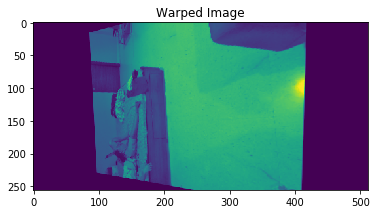

11
here


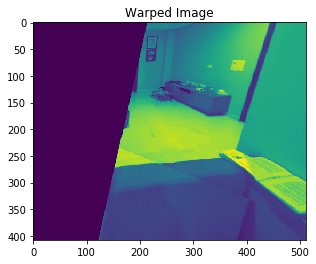

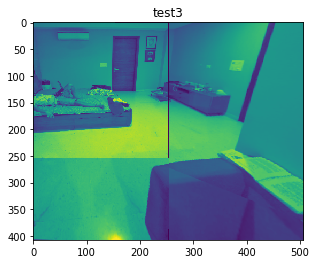

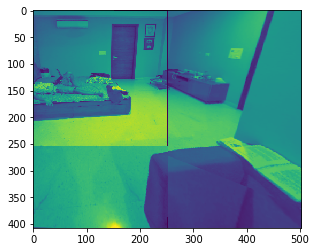

In [287]:
img = images_bottom[0]
rows,cols = img.shape
M = cv.getRotationMatrix2D((cols/2,rows/2),90,1)
dst = cv.warpAffine(img,M,(cols,rows))
# plt.imshow(dst),plt.title("dst")
# plt.show()
# plt.figure()

img = images_top[0]
rows,cols = img.shape
M = cv.getRotationMatrix2D((cols/2,rows/2),90,1)
dst1 = cv.warpAffine(img,M,(cols,rows))
# plt.imshow(dst2),plt.title("ds2")
# plt.show()
# plt.figure()


kp1,kp2,des1,des2 = find_keypoints(dst1,dst)

H = find_homography(kp1,kp2,des1,des2)

if len(H) > 0 :
    print("here")
    dst = stitch_images(dst1,dst,H)
    rows,cols = dst.shape
    dst1 = ndimage.rotate(dst, 270)
#     plt.imshow(dst1),plt.title("test")
#     plt.show()
#     plt.figure()
#     dst1 = cropImage(dst1)
#     plt.imshow(dst1)
    
##############
img = images_bottom[1]
rows,cols = img.shape
M = cv.getRotationMatrix2D((cols/2,rows/2),90,1)
dst = cv.warpAffine(img,M,(cols,rows))
# plt.imshow(dst),plt.title("dst3")
# plt.show()
# plt.figure()

img = images_top[1]
rows,cols = img.shape
M = cv.getRotationMatrix2D((cols/2,rows/2),90,1)
dst2 = cv.warpAffine(img,M,(cols,rows))
# plt.imshow(dst2),plt.title("ds4")
# plt.show()
# plt.figure()


kp1,kp2,des1,des2 = find_keypoints(dst2,dst)

H = find_homography(kp1,kp2,des1,des2)

if len(H) > 0 :
    print("here")
    dst = stitch_images(dst2,dst,H)
    rows,cols = dst.shape
    dst2 = ndimage.rotate(dst, 270)
#     plt.imshow(dst2),plt.title("test2")
#     plt.show()
#     plt.figure()
#     dst2 = cropImage(dst2)
#     plt.imshow(dst2)
    
    

    
kp1,kp2,des1,des2 = find_keypoints(dst2,dst1)

H = find_homography(kp1,kp2,des1,des2)

if len(H) > 0 :
    print("here")
    dst = stitch_images(dst2,dst1,H)
#     rows,cols = dst.shape
#     dst2 = ndimage.rotate(dst, 270)
#     M = cv.getRotationMatrix2D((rows/2,cols/2),90,1)
#     dst2 = cv.warpAffine(dst,M,(rows,cols))
    plt.imshow(dst),plt.title("test3")
    plt.show()
    plt.figure()
    dst = cropImage(dst)
    plt.imshow(dst)